# Predicting Age and Gender Using Convolution Neural Networks

Abstract:
In this Notebook it will be atempted to predict age and gender using a Convolution Neural Network.
For this study case it will be used data from the UTKFace : https://susanqq.github.io/UTKFace/ (more details in the website)
This project tried to be as real life as possible starting with untreated data in order for the data to be processed and better suited for the objective, and also to learn more from the entire process and the inerhent difficulties each step of data engineering carries.

Observations:
The final approach ended up using pre trained models, however a model for each model was created from scratch but since the yelded results were not satisfatory they did not make the final cut, the code for those will be after the conclusions as well as some other parts for any continuation on the project and improvement upon it.

In [1]:
#imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import random
import tensorflow as tf
import time
import cv2 as cv
import math

from tensorflow import keras
from keras.constraints import maxnorm
from retinaface import RetinaFace
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential, load_model


In [ ]:
#run to loop the "the_path" folder and from it gather the faces from the pictures with the face rotated in order for
#the eyes to be in a horizontal manner.

the_path = "C:/Users/fmfdu/IronHackCourseAll/FINAL_PROJECT/facepics/Nova_pasta/big_test"
images = []
gender = []
age = []

for img in os.listdir(the_path):
    #skips the iteration in case image is not found and returns an error
    try:
        faces = cv.imread(str(the_path)+"/"+str(img))
        #extracts the face from the image
        faces = RetinaFace.extract_faces(faces, align=True)
        for face in faces:
            down_width = 200
            down_height = 300
            down_points = (down_width, down_height)
            #resizes the image to the desired dimensions
            treated_face = cv.resize(face, down_points, interpolation= cv.INTER_LINEAR)
            #if face is not found continue iteration and disregard the not found picture
            if treated_face.shape == (0,):
                #warning to know how many faces retinaface did not find and returned "(0,)"
                print("bananas_podres")
                continue
            #get the gender value from picture name    
            genders = img.split("_")[1]
            #get the age value from picture name
            ages = img.split("_")[0]
            age.append(np.array(ages))
            gender.append(np.array(genders))
            images.append(np.array(treated_face))
    except:
        #gives warning in case the image is not read
        print("bananas_estragadas")
        continue

age = np.array(age, dtype=np.int64)
gender = np.array(gender, np.uint64)
images = np.array(images)

In [ ]:
#Saving the previously treated images in a picke file in order not to run the whole process everytime
#obs: 8000 images take around 6-8 hours to process
file = open("test_a_cores_gigante.pickle", "wb")
pickle.dump(age, file)
pickle.dump(gender, file)
pickle.dump(images, file)

file.close()

In [2]:
#load the processed images from the pickle file created
file  = open("test_a_cores_gigante.pickle","rb")
age = pickle.load(file)
gender = pickle.load(file)
images = pickle.load(file)

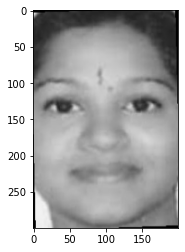

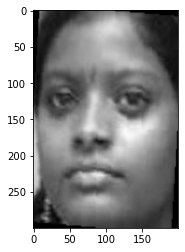

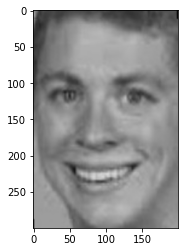

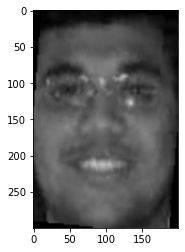

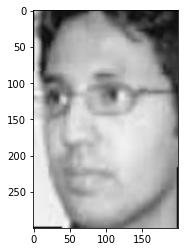

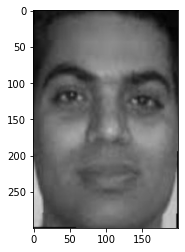

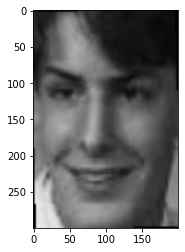

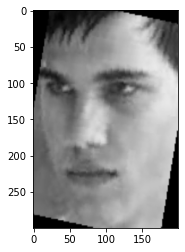

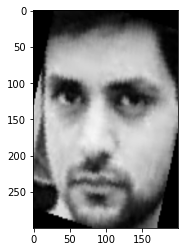

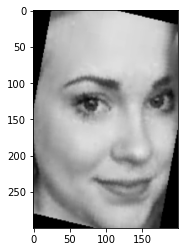

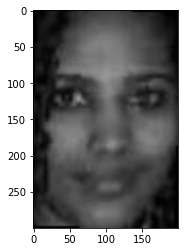

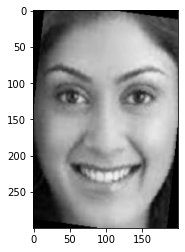

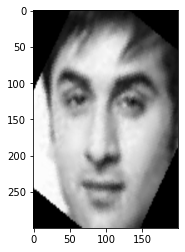

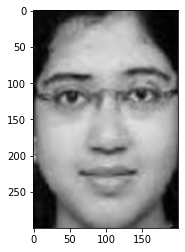

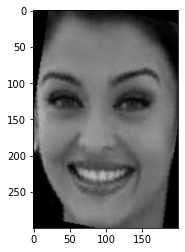

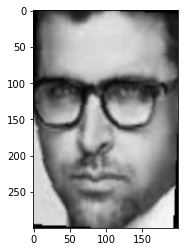

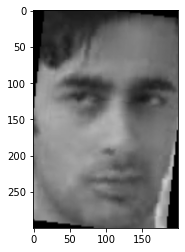

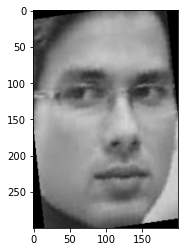

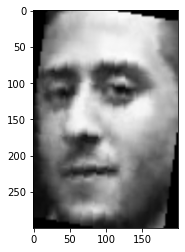

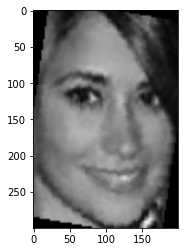

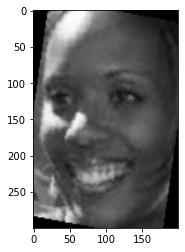

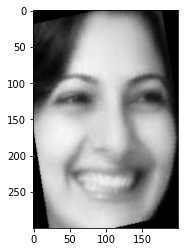

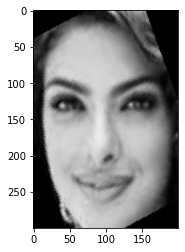

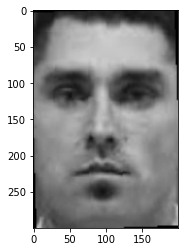

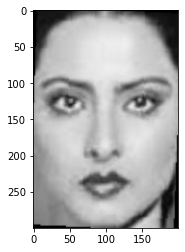

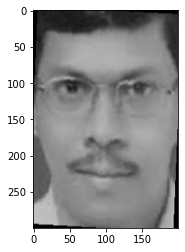

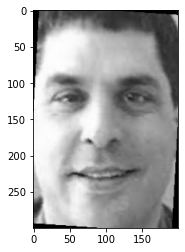

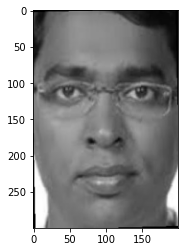

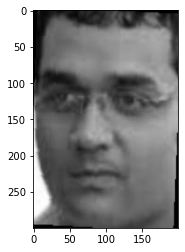

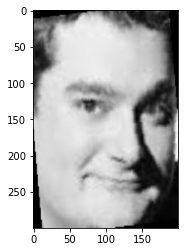

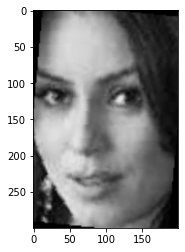

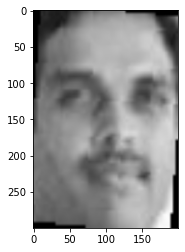

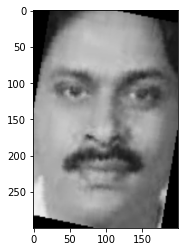

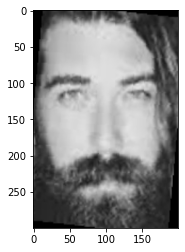

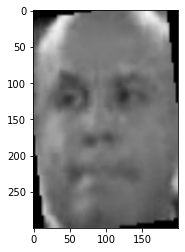

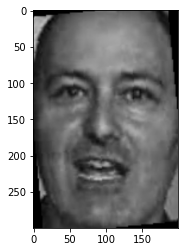

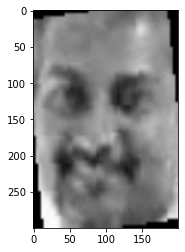

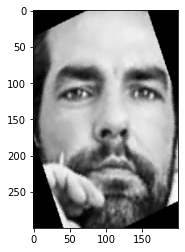

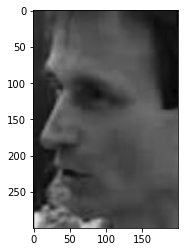

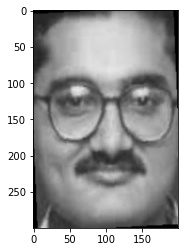

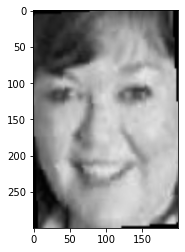

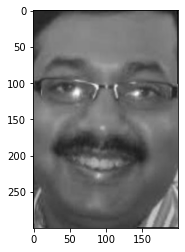

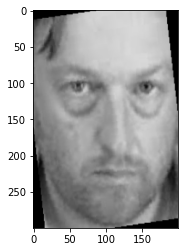

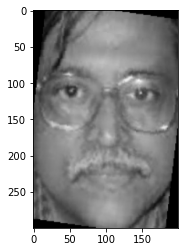

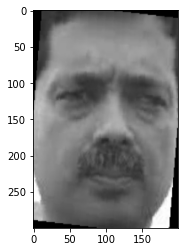

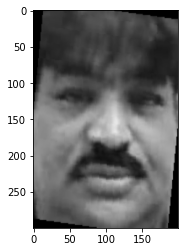

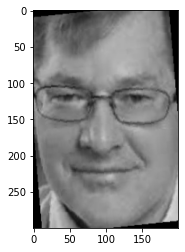

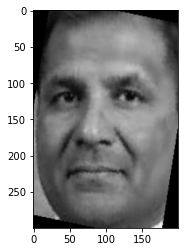

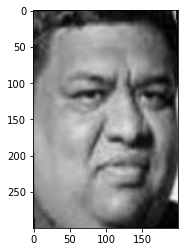

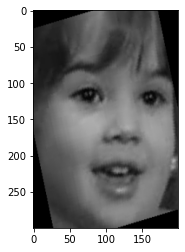

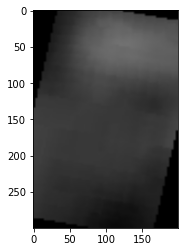

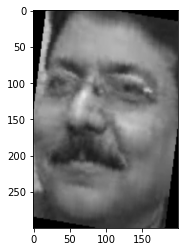

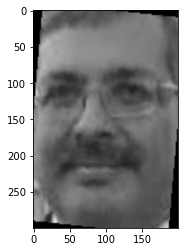

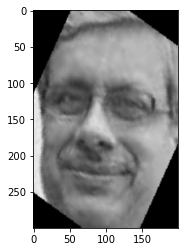

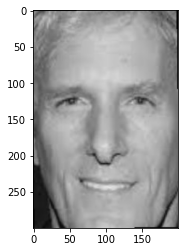

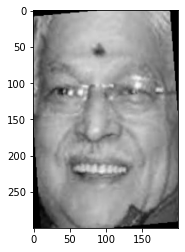

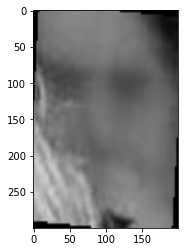

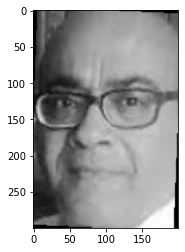

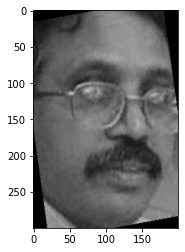

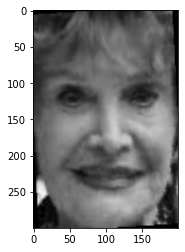

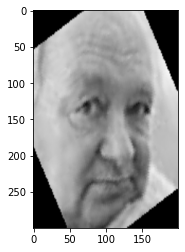

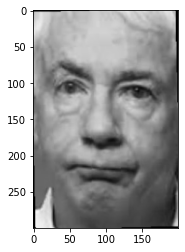

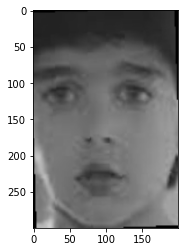

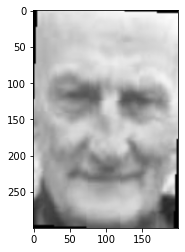

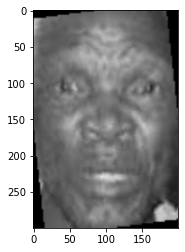

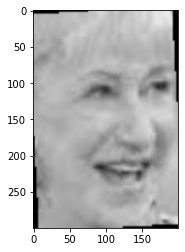

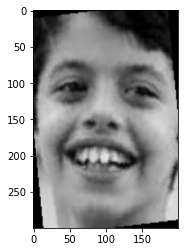

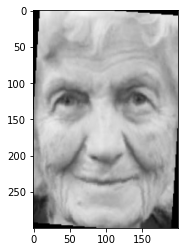

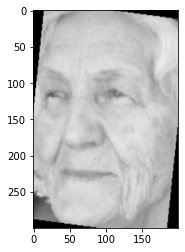

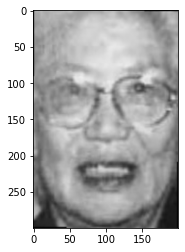

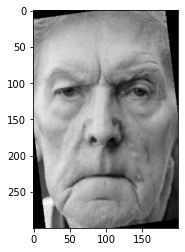

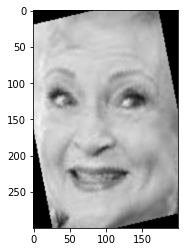

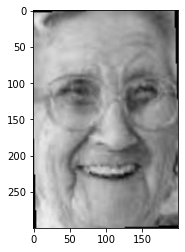

In [39]:
#checking the different resolutions in some of the pictures in grayscale (used in a smaller sample when crating CNN model from
#scratch, the version from scratch will be in the end of the notebook as extras that did not make the final cut)
for face in images:
    face1 = cv.cvtColor(face,cv.COLOR_RGB2gray)
    plt.imshow(face1)
    plt.show()

In [4]:
#replace the one empy value with male (this only value was a picture with the incorrect formatting hence the empty string)

gender = list(map(lambda x: 1 if x == '' else x, gender))

x=np.array(gender)

unique, counts = np.unique(x, return_counts=True)

result = np.column_stack((unique, counts)) 
print (result)

[['0' '4495']
 ['1' '3738']]


In [5]:
#transforming all values in gender into integers
gender = list(map(int, gender))

In [6]:
#creating the 2 splits, one for the age model and the other for the gender model

#training age data split
x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(images, age, random_state=42)

#training gender data split
x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(images, gender, random_state=42)

In [7]:
# first need to normalize the values, since they are pixel values (0 to 255) dividing by 255 will normalize the values

#for age model
x_train_age[:] = [x / 255 for x in x_train_age]
x_test_age[:] = [x / 255 for x in x_test_age]

#for gender model
x_train_gender[:] = [x / 255 for x in x_train_gender]
x_test_gender[:] = [x / 255 for x in x_test_gender]

# Age Model

In earlier tries a model from scratch was built but that approach got worse results than the pre trained model

In [7]:
#loading the pre-trained model

base_model1 = VGG16(input_shape = (300, 200, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

In [8]:
for layer in base_model1.layers:
    layer.trainable = False

In [9]:
#add conv layers 
#add max pooling

# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model1.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(8, activation='relu')(x)
x = layers.Dense(16, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(16, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model1 = tf.keras.models.Model(base_model1.input, x)

model1.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'mse',metrics = ['mae','mse'])

In [10]:
#fitting the model
vgghist1 = model1.fit(np.array(x_train_age), np.array(y_train_age),batch_size=16, steps_per_epoch = 100, epochs = 10)

Epoch 1/10
100/100 [==============================] - 213s 2s/step - loss: 1424.7885 - mae: 34.8766 - mse: 1424.7885
Epoch 2/10
100/100 [==============================] - 209s 2s/step - loss: 1425.5138 - mae: 34.9985 - mse: 1425.5138
Epoch 3/10
100/100 [==============================] - 209s 2s/step - loss: 1508.2834 - mae: 35.8913 - mse: 1508.2834
Epoch 4/10
100/100 [==============================] - 209s 2s/step - loss: 1448.7050 - mae: 35.1896 - mse: 1448.7050
Epoch 5/10
100/100 [==============================] - 209s 2s/step - loss: 1445.4353 - mae: 35.2213 - mse: 1445.4353
Epoch 6/10
100/100 [==============================] - 209s 2s/step - loss: 1434.5039 - mae: 35.0938 - mse: 1434.5039
Epoch 7/10
100/100 [==============================] - 209s 2s/step - loss: 1482.7712 - mae: 35.5100 - mse: 1482.7712
Epoch 8/10
100/100 [==============================] - 209s 2s/step - loss: 1433.3298 - mae: 35.0494 - mse: 1433.3298
Epoch 9/10
100/100 [==============================] - 209s 2s/st

In [12]:
#saving the model
model1.save("Age_test_big_data.model")

INFO:tensorflow:Assets written to: Age_test_big_data.model\assets


Age model conclusions:

From the observed data it is possible to see that a 35.3 years average error is quite big, this could be due to the quality of many of the pictures which was not the best and therefore made harder for the CNN to find patterns in the faces and the data sample being a bit too small even having around 6000 images. If we divide 6000 by 110 possible years we get around 55 pictures for each age for the model to learn which also divided by males and females (since they have distinct 

# Gender Model

In [8]:
#loading the pre-trained model

base_model = VGG16(input_shape = (300, 200, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

In [9]:
for layer in base_model.layers:
    layer.trainable = False

In [10]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(4, activation='relu')(x)
x = layers.Dense(8, activation='relu')(x)
x = layers.Dense(4, activation='relu')(x)

# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001), loss = 'binary_crossentropy',metrics = ['accuracy'])

In [12]:
#fitting the model
vgghist = model.fit(np.array(x_train_gender), np.array(y_train_gender),batch_size=8, steps_per_epoch = 100, epochs = 50)

Epoch 1/50
100/100 [==============================] - 112s 1s/step - loss: 0.6901 - accuracy: 0.5788
Epoch 2/50
100/100 [==============================] - 107s 1s/step - loss: 0.6918 - accuracy: 0.5387
Epoch 3/50
100/100 [==============================] - 107s 1s/step - loss: 0.6915 - accuracy: 0.5375
Epoch 4/50
100/100 [==============================] - 107s 1s/step - loss: 0.6955 - accuracy: 0.5138
Epoch 5/50
100/100 [==============================] - 106s 1s/step - loss: 0.6907 - accuracy: 0.5437
Epoch 6/50
100/100 [==============================] - 107s 1s/step - loss: 0.6884 - accuracy: 0.5638
Epoch 7/50
100/100 [==============================] - 107s 1s/step - loss: 0.6908 - accuracy: 0.5362
Epoch 8/50
100/100 [==============================] - 106s 1s/step - loss: 0.6897 - accuracy: 0.5451
Epoch 9/50
100/100 [==============================] - 107s 1s/step - loss: 0.6852 - accuracy: 0.5775
Epoch 10/50
100/100 [==============================] - 107s 1s/step - loss: 0.6930 - accura

In [13]:
#saving the model
model.save("gender_big_train.model")

INFO:tensorflow:Assets written to: gender_big_train03.model\assets


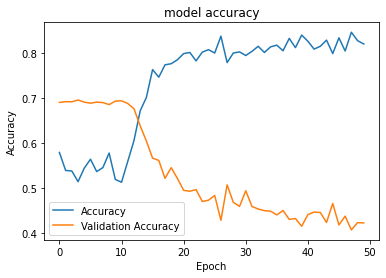

In [14]:
#ploting the evolution

plt.plot(vgghist.history["accuracy"])
#plt.plot(vgghist.history['val_acc'])
plt.plot(vgghist.history['loss'])
#plt.plot(vgghist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Loss","loss","Validation Loss"])
plt.show()

Conclusions from the gender model:
Since this model had to solve a binary classification problem and the data was around 54% males and 46% females (close to perfectly balanced) the model could learn very well between the 10th and 20th epoch. This was not the best model generated out of the tries, the best one generated around 87% accuracy where this one only generated 82% being still a very good score considering the fact that the quality of many images was not the greatest and that babies were present in the data and also extremely hard to differentiate gender between them.

# Extra code that did not make the cut or needs improvement

In [ ]:
#age model

model = Sequential()

#this model can have grayscaled or 1 colour schemes as well as RGB, only need to change input shape (x,y,z) to z=1 or z=3
model.add(Conv2D(128, kernel_size=3,activation='relu', input_shape=(300,200,1)))
model.add(MaxPool2D(pool_size=3,strides=2))

model.add(Conv2D(128, kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=3,strides=2))

model.add(Conv2D(256, kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=3,strides=2))

model.add(Conv2D(128, kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=3,strides=2))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(256,activation='relu'))

model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam',loss='mse',metrics=['mae','mse'])

model.fit(np.array(x_train_age), np.array(y_train_age), steps_per_epoch = 500, epochs = 50)

In [ ]:
#gender model

gender_model = Sequential()

#this model can have grayscaled or 1 colour schemes as well as RGB, only need to change input shape (x,y,z) to z=1 or z=3
gender_model.add(Conv2D(64, kernel_size=3,activation='relu', input_shape=(300,200,1)))
gender_model.add(MaxPool2D(pool_size=3,strides=2))

gender_model.add(Conv2D(128, kernel_size=3,activation='relu'))
gender_model.add(MaxPool2D(pool_size=3,strides=2))

gender_model.add(Conv2D(256, kernel_size=3,activation='relu'))
gender_model.add(MaxPool2D(pool_size=3,strides=2))

gender_model.add(Conv2D(512, kernel_size=3,activation='relu'))
gender_model.add(MaxPool2D(pool_size=3,strides=2))

gender_model.add(Flatten())
gender_model.add(Dropout(0.2))
gender_model.add(Dense(256,activation='relu'))

model.add(Dense(1, activation='sigmoid'))

gender_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

gender_model.fit(np.array(x_train_age), np.array(y_train_age), steps_per_epoch = 500, epochs = 50)

In [12]:
#beggining of trying to predict an image from outside the dataset with the trained model

def prepare(the_path):
    faces = cv.imread(str(the_path))
    faces = RetinaFace.extract_faces(faces, align=True)
    for face in faces:
        down_width = 200
        down_height = 300
        down_points = (down_width, down_height)
        treated_face = cv.resize(face, down_points, interpolation= cv.INTER_LINEAR)
    return treated_face.reshape(-1,down_height,down_width,3)
    
Categories = ["Male","Female"]
    
model_gender = tf.keras.models.load_model("gender_big_train01.model")

prediction1 = model_gender.predict(prepare('C:/Users/fmfdu/IronHackCourseAll/FINAL_PROJECT/facepics/Nova_pasta/pred_test/woman01.jpg'))
print(prediction1)

[[1.]]


In [16]:
model_age = tf.keras.models.load_model("Age_test_big_data.model")

prediction = model_age.predict(prepare('C:/Users/fmfdu/IronHackCourseAll/FINAL_PROJECT/facepics/Nova_pasta/pred_test/woman01.jpg'))
print(prediction)

[[1.]]
